# Geostrophic Balance

Here we study ocean surface currents in the Gulf of Mexico, modeled by the 2D incompressible Navier-Stokes equations on a rotating sphere:

$$ u_{t} + (\mathbf{u} \cdot \nabla)u + fv = -\frac{1}{\rho} p_{x} $$
$$ v_{t} + (\mathbf{u} \cdot \nabla)v - fu = -\frac{1}{\rho} p_{y} $$

where $\rho$ is the density, x and y are the zonal and meridional coordinates respectively. $f$, the Coriolis parameter is given in terms of the Earth's rotation rate $\Omega$ and the latitude $\phi$.

For this case study, the data is obtainable from this [URL](https://data.hycom.org/datasets/GOMu0.04/expt_50.1/data/netcdf/1993/) directly. The fields used are the first and second fields of the hindcasts (see path below).

This code was written based on the paper [[1]](https://www.nature.com/articles/s41467-021-21331-z) and the supplementary information [[2]](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-021-21331-z/MediaObjects/41467_2021_21331_MOESM1_ESM.pdf) provided for processing the data, and using some of the alternative code written in the Boundary Layer Notebook.

In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
import matplotlib.pyplot as plt
import sklearn as sk
import os

# adding Tools to the system path, and importing the modules
sys.path.insert(0, "../Tools/")
import plot_funcs as pf

In [2]:
# Creating the directory to save the plots
cur_dir = os.getcwd()
proj_dir = os.path.dirname(cur_dir)
plots_dir = os.path.join(proj_dir, "Plots/Geos_Bal")
os.makedirs(plots_dir, exist_ok=True)

## 1. Load the data


In [3]:
# Read in the data from the nc files at 2 times to get time derivatives

# path1 = "../Data/hycom_gomu_901m000_2019010112_t000.nc"
# path2 = "../Data/hycom_gomu_901m000_2019010112_t001.nc"
path1 = "../Data/hycom_gomu_501_1993010100_t000.nc"
path2 = "../Data/hycom_gomu_501_1993010100_t003.nc"

data_t1 = xr.open_dataset(path1, decode_times=False)
data_t2 = xr.open_dataset(path2, decode_times=False)

In [4]:
# Visualise what the data looks like
data_t1

<xarray.Dataset>
Dimensions:     (time: 1, depth: 40, lat: 346, lon: 541)
Coordinates:
  * time        (time) float64 -6.134e+04
  * depth       (depth) float64 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * lat         (lat) float64 18.12 18.16 18.2 18.24 ... 31.8 31.84 31.88 31.92
  * lon         (lon) float64 -98.0 -97.96 -97.92 -97.88 ... -76.48 -76.44 -76.4
Data variables:
    tau         (time) float64 ...
    water_u     (time, depth, lat, lon) float32 ...
    water_v     (time, depth, lat, lon) float32 ...
    water_temp  (time, depth, lat, lon) float32 ...
    salinity    (time, depth, lat, lon) float32 ...
    surf_el     (time, lat, lon) float32 ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Naval Oceanographic Office
    source:                    HYCOM archive file
    history:                   archv2ncdf3z
    field_type:                instantaneous
    Conventions:               CF-1.6 NAVO_netcdf_v1.1

In [5]:
data_t2

<xarray.Dataset>
Dimensions:     (time: 1, depth: 40, lat: 346, lon: 541)
Coordinates:
  * time        (time) float64 -6.134e+04
  * depth       (depth) float64 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * lat         (lat) float64 18.12 18.16 18.2 18.24 ... 31.8 31.84 31.88 31.92
  * lon         (lon) float64 -98.0 -97.96 -97.92 -97.88 ... -76.48 -76.44 -76.4
Data variables:
    tau         (time) float64 ...
    water_u     (time, depth, lat, lon) float32 ...
    water_v     (time, depth, lat, lon) float32 ...
    water_temp  (time, depth, lat, lon) float32 ...
    salinity    (time, depth, lat, lon) float32 ...
    surf_el     (time, lat, lon) float32 ...
Attributes:
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    classification_authority:  not applicable
    institution:               Naval Oceanographic Office
    source:                    HYCOM archive file
    history:                   archv2ncdf3z
    field_type:                instantaneous
    Conventions:               CF-1.6 NAVO_netcdf_v1.1

In those variables, the only ones needed are the `water_u`, `water_v`, `time`, `lon`, and `lat` variables. Attention must be payed to the meridional axis being flipped here. The latitude increases as you go down the rows.

In [6]:
# Get the necessary variables
lat = data_t1["lat"].values
lon = data_t1["lon"].values

# Stack the two time snapshots
u = np.array([data_t1["water_u"].values, data_t2["water_u"].values])
u = u[:, 0, 0, :, :]

v = np.array([data_t1["water_v"].values, data_t2["water_v"].values])
v = v[:, 0, 0, :, :]

# Set some domain characteristics
nx = len(lon)
ny = len(lat)
omega = 7.29e-5  # rad/s
f = 2 * omega * np.sin(lat * np.pi / 180)
rho = 1030  # kg/m^3, assuming constant density

In [7]:
# Set the time and space step sizes
R = 6.37e6  # m, Earth radius
dt = 3 * 3600  # 3 hours
# Because dx is variable due to it varying with latitude,
# we calculate it for each latitude
dx = (1 / 25) * (1 / 360) * 2 * np.pi * R * np.cos(lat * np.pi / 180)
x = np.zeros((ny, nx))
for i in range(ny):
    x[i, :] = np.cumsum(np.concatenate(([0], np.repeat(dx[i], nx - 1))))
dy = (1 / 25) * (1 / 360) * 2 * np.pi * R  # Assuming constant Earth radius meriodionaly

In [8]:
# Check shapes: Should be (2, ny, nx)
x.shape, u.shape, v.shape

((346, 541), (2, 346, 541), (2, 346, 541))

## 2. Getting the derivatives

From the studied equation, we need x and y derivatives of u, v, and p, and the time derivative of u and v.

For this, we'll use finite difference, following the alternative methods written for the Boundary Layer case (see `Boundary_Layer.ipynb`)

In [9]:
def get_derivatives_numpy_geo(nx, ny, x, dy, u, v):
    """Get the derivatives for the 2D domain

    Parameters:
    -----------
    nx: int
        Number of points in the x-direction
    ny: int
        Number of points in the y-direction
    x: numpy array
        Array of x points
    dy: float
        Spacing in the y-direction
    u: numpy array
        Array of u velocities
    v: numpy array
        Array of v velocities


    Returns:
    --------
    u_x: numpy array
        x-derivative of u
    u_y: numpy array
        y-derivative of u
    v_x: numpy array
        x-derivative of v
    v_y: numpy array
        y-derivative of v
    """

    # Initialise the arrays
    u_x = np.zeros((ny, nx))
    u_y = np.zeros((ny, nx))
    v_x = np.zeros((ny, nx))
    v_y = np.zeros((ny, nx))

    # Get the derivatives
    for i in range(ny):
        u_x[i, :] = np.gradient(u[i, :], x[i])
        v_x[i, :] = np.gradient(v[i, :], x[i])

    u_y = np.gradient(u, dy, axis=0)
    v_y = np.gradient(v, dy, axis=0)

    return u_x, u_y, v_x, v_y

In [10]:
# Get the derivatives
u_x, u_y, v_x, v_y = get_derivatives_numpy_geo(nx, ny, dx, dy, u[0], v[0])

In [11]:
# Get the time derivatives
u_t = (u[1] - u[0]) / dt
v_t = (v[1] - v[0]) / dt

# Define the terms
u_grad_u = u[0] * u_x + v[0] * u_y
u_grad_v = u[0] * v_x + v[0] * v_y

# Get the Coriolis term
f = f.reshape(ny, 1)
f_u = -f * u[0]
f_v = f * v[0]

# Get the pressure gradient term
p_x = -rho * (u_t + u_grad_u + f_v)
p_y = -rho * (v_t + u_grad_v + f_u)

What the flow in the gulf of mexico looks like can be visualised with a vorticity field, as it is in the Supplementary Figure 10. However, it can be seen vortices in this snapshot are much larger than in the supplementary information, so there may be a difference in the data used.

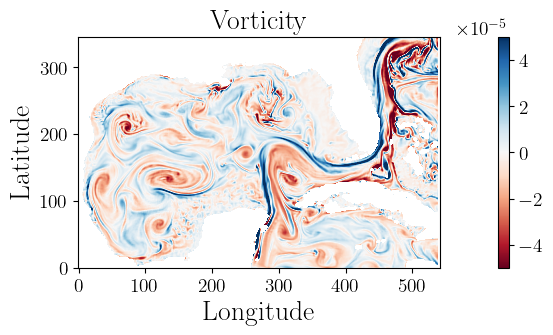

In [12]:
# Plot a vorticity field for visualisation
field = v_x - u_y
plt.imshow(
    field,
    cmap="RdBu",
    origin="lower",
    vmin=-5e-5,
    vmax=5e-5,
)
plt.title("Vorticity")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar()
plt.show()

In [13]:
# Define the features

# Flatten the terms
u_t = u_t.flatten()
v_t = v_t.flatten()
u_grad_u = u_grad_u.flatten()
u_grad_v = u_grad_v.flatten()
f_u = f_u.flatten()
f_v = f_v.flatten()
p_x = p_x.flatten()
p_y = p_y.flatten()

In [14]:
# Stack the features for each direction
features_mer = pd.DataFrame(
    {
        "u_t": u_t,
        "u_grad_u": u_grad_u,
        "f_v": f_v,
        "-p_x_over_rho": p_x / rho,
    }
)

features_zon = pd.DataFrame(
    {
        "v_t": v_t,
        "u_grad_v": u_grad_v,
        "f_u": f_u,
        "-p_y_over_rho": p_y / rho,
    }
)

features_mer = features_mer.to_numpy()
features_zon = features_zon.to_numpy()

nfeatures = 4

In [15]:
# Define labels:
labels = [
    r"$\mathbf{u}_{t}$",
    r"$(\mathbf{u} \cdot \nabla)\mathbf{u}$",
    r"$Cor$",
    r"$-\frac{1}{\rho} \nabla p$",
]

Based on the results in the [supplementary informations](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-021-21331-z/MediaObjects/41467_2021_21331_MOESM1_ESM.pdf), the general dominant balance model identification is done using both the meridional and zonal components, but which points belong to which component needs to be tracked for the spatial representation.

In [16]:
# Get rid of nan values, keeping tracks of the indices
mer_nan = np.isnan(features_mer).any(axis=1)
zon_nan = np.isnan(features_zon).any(axis=1)
features_mer = features_mer[~np.isnan(features_mer).any(axis=1)]
features_zon = features_zon[~np.isnan(features_zon).any(axis=1)]

# Combine the meridional and zonal features
features = np.concatenate((features_mer, features_zon), axis=0)

When using the features as is, they were all of order $10^{-5}$ which the GMM clustering algorithm struggled with leading to a diagonal covariance matrix, i.e. the model identified no relationship between features. Thus they are scaled to be of order 1.

In [17]:
# Scale the features
features = features * 1e5

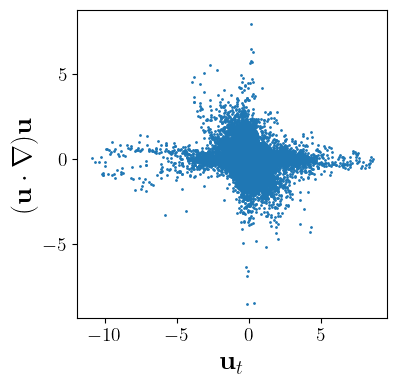

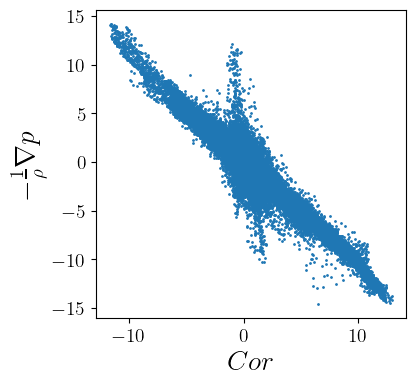

In [18]:
plt.figure(figsize=(4, 4))

# Plot the features
plt.scatter(features[:, 0], features[:, 1], s=1)
plt.xlabel(labels[0])
plt.ylabel(labels[1])
plt.show()

plt.figure(figsize=(4, 4))
plt.scatter(features[:, 2], features[:, 3], s=1)
plt.xlabel(labels[2])
plt.ylabel(labels[3])
plt.show()

In these 2 scatterplots, it is clear to see that a lot of points are going to have a large covariance between the pressure gradient force and the Coriolis force, which could correspond to the geostrophic balance.

## 3. Gaussian Mixture Model Clustering

As stated above, the GMM clustering in ran on the full data, with the meridional and zonal components combined. However, only 50% of the data is used for faster training and it is sufficient for the clustering to capture the balance models

In [19]:
seed = 75016
np.random.seed(seed)

# Fit the model on 50% of the data
frac = 0.5
features_train, _ = sk.model_selection.train_test_split(
    features, train_size=frac, random_state=seed
)

n_clusters = 6
model = GaussianMixture(n_components=n_clusters, random_state=seed)
model.fit(features_train)

GaussianMixture(n_components=6, random_state=75016)

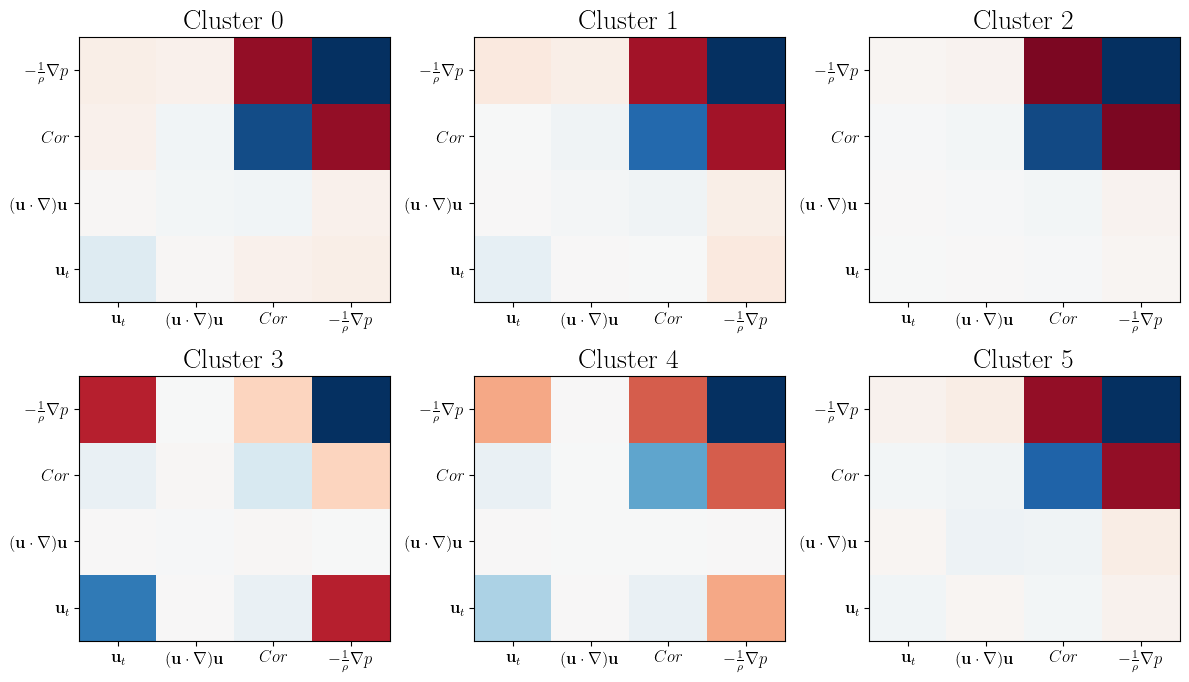

In [20]:
pf.plot_cov_mat(model, nfeatures, n_clusters, labels, "GMM", "Geos_Bal/cov_mat.png")

As can be seen, a large majority of the cluster seem to have the same active terms, PGF and Coriolis, with 2 clusters having $u_t$ as a potentially active term

In [21]:
# Predict clusters for the entire dataset, for a single snapshot
cluster_idx = model.predict(features)

In [22]:
import seaborn as sns
from matplotlib.colors import ListedColormap
import os

# Set the colormap
cm = sns.color_palette("tab10").as_hex()
cm.insert(0, "#ffffff")
cm = ListedColormap(cm)

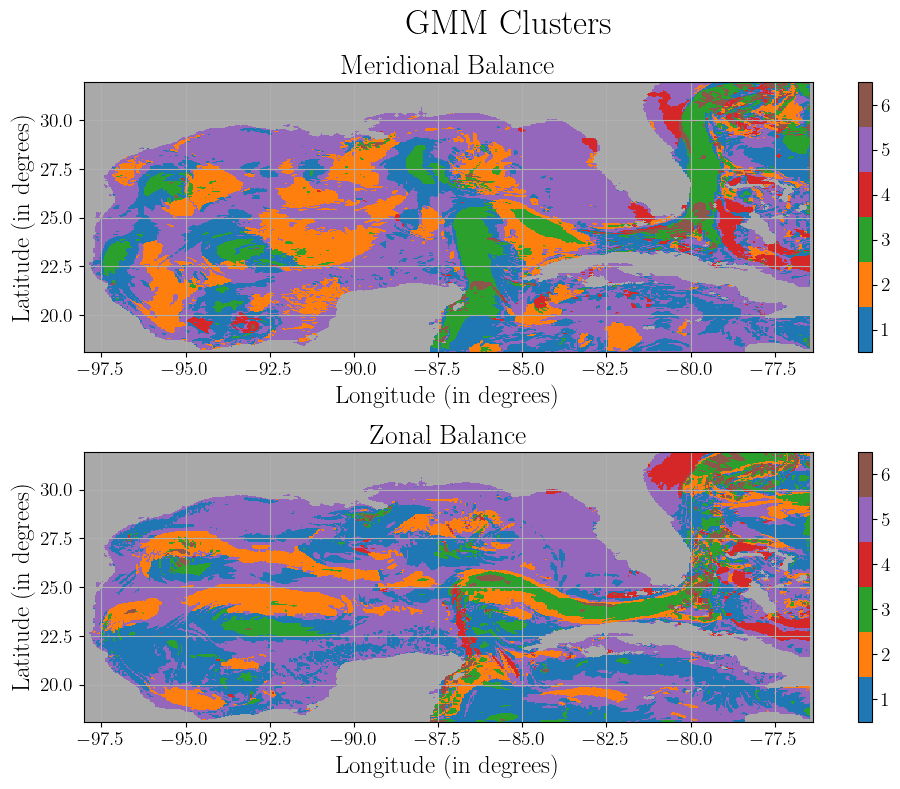

In [23]:
# Get the meridional and zonal points back
n_meridional = len(features_mer[:, 0])

# Initialise the cluster indices
cluster_idx_mer = np.zeros(len(u[0, :, :].flatten()))
cluster_idx_zon = np.zeros(len(u[0, :, :].flatten()))

# Fill the nan values back in
cluster_idx_mer[mer_nan] = np.NaN
cluster_idx_zon[zon_nan] = np.NaN

# Fill the cluster indices
cluster_idx_mer[~mer_nan] = cluster_idx[:n_meridional]
cluster_idx_zon[~zon_nan] = cluster_idx[n_meridional:]

# Reshape the cluster indices
clustermap_mer = cluster_idx_mer.reshape(ny, nx)
clustermap_zon = cluster_idx_zon.reshape(ny, nx)

# Plot the clusters in space
pf.plot_clustering_space_geo(
    clustermap_mer, clustermap_zon, lon, lat, n_clusters, "Geos_Bal/clusters.png"
)

Comparing with the vorticity field plot, there is an overlap of where vortices are and where the clusters have strong pressure-coriolis covariancec only. This follows the general expectation that geostrophic balance is associated with rotating flow.

## 3.  SPCA identification of active terms

Using the alternative method written in the Boundary Layer case notebook, the residuals for each regularization value $\alpha$ is calculated as the $l_{2}$-norm of the neglected terms across all clusters (see [Supplementary Information](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-021-21331-z/MediaObjects/41467_2021_21331_MOESM1_ESM.pdf))

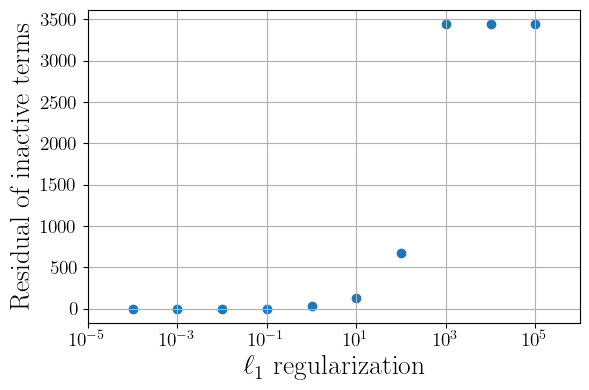

In [24]:
alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])


def spca_err(alpha, cluster_idx, features, nc):
    err_ = 0

    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.where(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alpha)
        spca.fit(cluster_features)

        # Identify active and inactive terms
        active_terms = np.where(spca.components_[0] != 0)[0]
        inactive_terms = np.where(spca.components_[0] == 0)[0]

        err_ += np.sqrt(np.sum((cluster_features[:, inactive_terms].ravel()) ** 2))

    return err_


from joblib import Parallel, delayed

err = Parallel(n_jobs=4)(
    delayed(spca_err)(alpha, cluster_idx, features, n_clusters) for alpha in alphas
)

pf.plot_spca_residuals(alphas, err, "Geos_Bal/spca_residuals.png")

So here, similar to in the Boundary Layer case, the optimal $\alpha$ value appears to be between 10 and 100. In order to obtain the same balance models as in the paper the alpha value is set to 40.

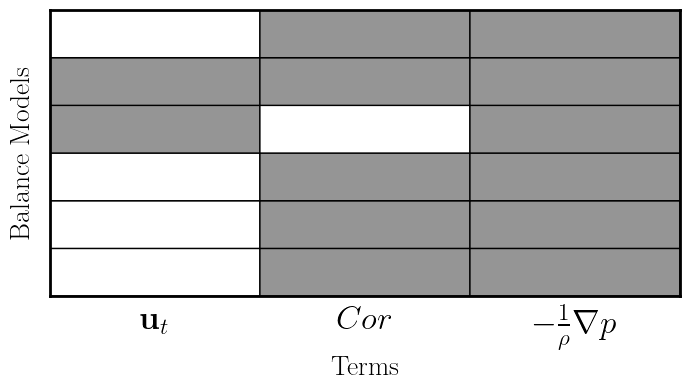

In [25]:
# Set the alpha regularization term to 40
alpha = 40

# Initialize the sparse PCA model
spca_model = np.zeros((n_clusters, nfeatures))

for i in range(n_clusters):
    feature_idx = np.where(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha, random_state=seed)
    spca.fit(cluster_features)

    active_terms = np.where(spca.components_[0] != 0)[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

pf.plot_balance_models(spca_model, labels, False, "Geos_Bal/active_terms.png")

## 4. Get Unique Dominant Balance Models

Again, using the alternative code, which uses `pandas`' `.groupby()` method, the unique balance models are obtained

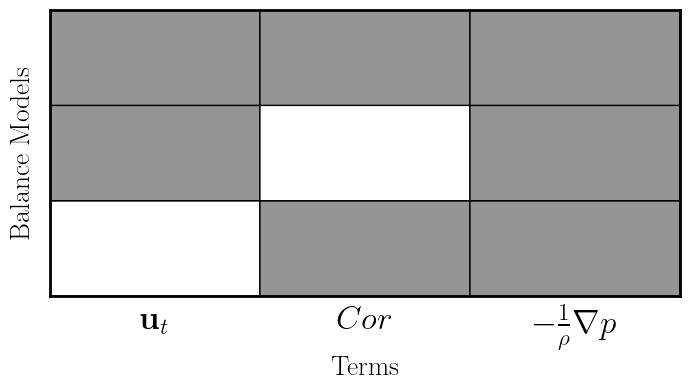

In [26]:
# Convert the spca_model array to a dataframe
spca_temp = pd.DataFrame(spca_model.copy())

# Group the balance models by the values of all columns
grouped_models = spca_temp.groupby(np.arange(nfeatures).tolist())
grouped_models = grouped_models.groups.items()

# Combine balance models that have identical active terms
# For each balance model, the spca models that have the same active terms
# are given the same index
balance_models = pd.DataFrame(np.zeros((len(grouped_models), nfeatures)))
model_idx = np.zeros(len(spca_model), dtype=int)
for i, model in enumerate(grouped_models):
    idx = model[1].to_list()
    model_idx[idx] = i
    balance_models.loc[i] = spca_temp.loc[idx[0]].to_numpy()


# Convert the balance models to a numpy array
balance_models = balance_models.drop_duplicates(keep="first")
balance_models = balance_models.to_numpy()
nmodels = balance_models.shape[0]


# Plot a grid of the active terms
pf.plot_balance_models(balance_models, labels, False, "Geos_Bal/final_active_terms.png")

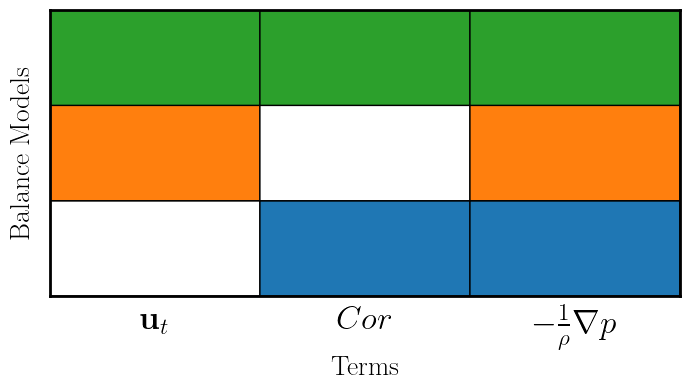

In [27]:
# Plot the balance models in a grid
pf.plot_balance_models(balance_models, labels, True, "Geos_Bal/balance_models.png")

In [28]:
# Assign the new cluster indices
balance_idx = np.array([model_idx[i] for i in cluster_idx])

n_meridional = len(features_mer[:, 0])

balance_idx_mer = np.zeros(len(u[0].flatten()))
balance_idx_zon = np.zeros(len(u[0].flatten()))

balance_idx_mer[mer_nan] = np.NaN
balance_idx_zon[zon_nan] = np.NaN

balance_idx_mer[~mer_nan] = balance_idx[:n_meridional]
balance_idx_zon[~zon_nan] = balance_idx[n_meridional:]


balancemap_mer = balance_idx_mer.reshape(ny, nx)
balancemap_zon = balance_idx_zon.reshape(ny, nx)

Then plotting the clusters in space, it is again the case that geostrophic balance seems to hold in most places there is a strong vortex.

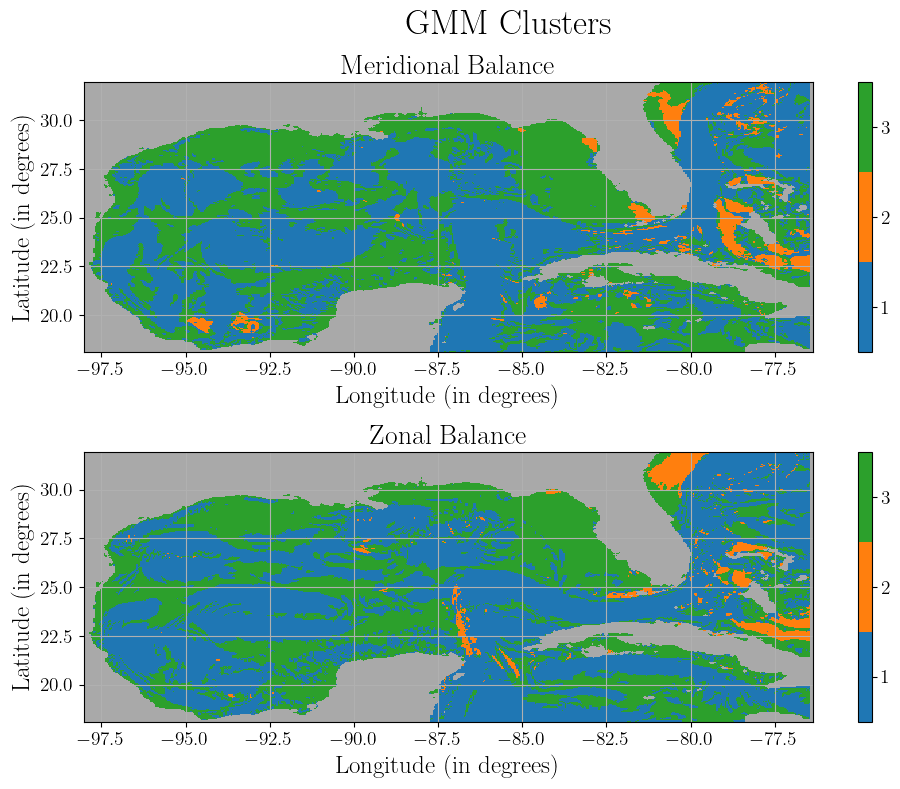

In [29]:
# Plot the balance models in space
pf.plot_clustering_space_geo(
    balancemap_mer,
    balancemap_zon,
    lon,
    lat,
    nmodels,
    "Geos_Bal/balance_models_space.png",
)